In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch
from torch import nn
from torch import optim
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, models

In [1]:
from torch.autograd import Variable
import torch.utils.data as data
import pandas as pd
import os
from PIL import Image
from torch.utils.data import DataLoader, TensorDataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
# Paths for training & validation data. 
# You should create './PatternProject/Train or Validation' folders in your google drive
train_path = '/content/drive/My Drive/PatternProject/Train/' 
valid_path = '/content/drive/My Drive/PatternProject/Validation/' 
#8:2든 7:3이든 나누고 그 안에서 train-normal/fracture, validation-normal/fracture 또 나눠야함

In [5]:
#Prepare training data set
classes = ['Normal','Fracture']

data =[]
label =[]
resize = transforms.Compose([transforms.CenterCrop(400)]) #image를 crop to 400

for i, d in enumerate(classes): #첫번째 for loop은 i=1, d=normal
    files = os.listdir(train_path+d)
    
    for f in files:
        img = Image.open(train_path+d+'/'+f,'r')
        img = resize(img)
        r,g,b = img.split() # same levels #rgb 중 한개만 가져오기
        one_img = np.asarray(np.float32(r)/255.0) #choose one
        img = np.asarray([one_img])
        data.append(img)
        label.append(i) #첫번째 loop 에서는 1 아니면 2라고 labeled
        

data = np.array(data, dtype='float32')
label = np.array(label, dtype='int64')

train_X = torch.from_numpy(data) #numpy to tensor
train_Y = torch.from_numpy(label)

train_X = train_X.type(torch.cuda.FloatTensor) #32bit
train_Y = train_Y.type(torch.cuda.LongTensor) #For CrossEntropy Loss

train_dataset = TensorDataset(train_X,train_Y)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [6]:
#Prepare validation data set

data =[]
label =[]

for i, d in enumerate(classes):
    files = os.listdir(valid_path+d)
    
    for f in files:
        img = Image.open(valid_path+d+'/'+f,'r')
        img = resize(img)
        r,g,b = img.split()
        one_img = np.asarray(np.float32(r)/255.0)
        img = np.asarray([one_img])
        data.append(img)
        label.append(i)
        
data = np.array(data, dtype='float32')
label = np.array(label, dtype='int64')

valid_X = torch.from_numpy(data)
valid_Y = torch.from_numpy(label)

valid_X = valid_X.type(torch.cuda.FloatTensor)
valid_Y = valid_Y.type(torch.cuda.LongTensor)

valid_dataset = TensorDataset(valid_X,valid_Y)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

torch.Size([32, 1, 400, 400])
Label = 0 : Normal image


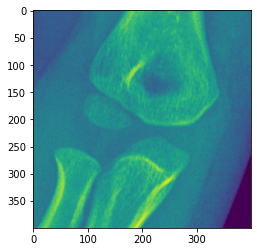

torch.Size([32, 1, 400, 400])
Label = 0 : Normal image


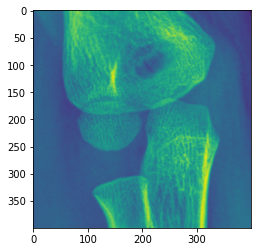

torch.Size([32, 1, 400, 400])
Label = 1 : Fracture image


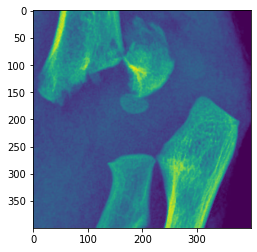

torch.Size([32, 1, 400, 400])
Label = 1 : Fracture image


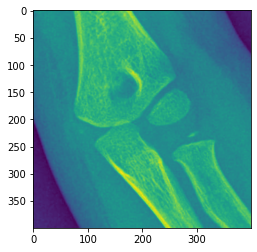

torch.Size([1, 1, 400, 400])
Label = 1 : Fracture image


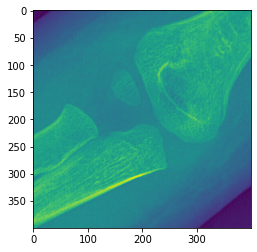

In [16]:
# Display images
# Not necessary for training. Just for confirmation
for images, labels in valid_loader:
        i, l = Variable(images), Variable(labels)
        print(i.size())
        i = i.cpu().numpy()
        l = l.cpu().numpy()
        if l[0]==0:
            print('Label = {} : Normal image'.format(l[0]))
        else:
            print('Label = {} : Fracture image'.format(l[0]))
        plt.imshow(i[0,0,:,:])
        plt.show()

In [7]:
# Build convolutional neural net
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, 3), #input channel(grayscale), output channel, kernerl size, stride=1, zero padding하지않음(default 찾아보기)
            nn.LeakyReLU(),
            nn.Conv2d(16, 16, 3), 
            nn.LeakyReLU(),
            nn.MaxPool2d(3,2), #overlapping pooling
            nn.Conv2d(16, 32, 3),
            nn.LeakyReLU(),
            nn.Conv2d(32, 32, 3),
            nn.LeakyReLU(),
            nn.Conv2d(32, 32, 3),
            nn.LeakyReLU(),
            nn.MaxPool2d(3,2),
            nn.Conv2d(32, 64, 3),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, 3),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, 3),
            nn.LeakyReLU(),
            nn.MaxPool2d(3,2),
            nn.Conv2d(64, 128, 3),
            nn.LeakyReLU(),
            nn.Conv2d(128, 128, 3),
            nn.LeakyReLU(),
            nn.Conv2d(128, 128, 3),
            nn.LeakyReLU(),
            nn.MaxPool2d(3,2),
        )
        
        self.avg_pool = nn.AvgPool2d(7)
      
        self.classifier = nn.Linear(512,2)

        for m in self.modules():
          if isinstance(m, nn.Linear):
            nn.init.kaiming_uniform_(m.weight.data)
          elif isinstance(m, nn.Conv2d):
            nn.init.kaiming_uniform_(m.weight.data)


    def forward(self, x):
        features = self.conv(x)
        x = self.avg_pool(features)
        x = x.view(features.size()[0],-1)
        x = self.classifier(x)
        return x


model = Net()

In [8]:
# Print the network you built
model.cuda()

Net(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (6): LeakyReLU(negative_slope=0.01)
    (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (10): LeakyReLU(negative_slope=0.01)
    (11): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (13): LeakyReLU(negative_slope=0.01)
    (14): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (15): LeakyReLU(negative_slope=0.01)
    (16): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (17): LeakyReLU(negative_slope=0.01)
    (1

In [9]:
# training
def run_train(model):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
    total_loss = 0
    correct = 0
    incorrect = 0
    
    for inputs, labels in train_loader:
        inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad()
        output = model(inputs)
        idx, pred = output.max(1)
        pred = (pred.detach().cpu().numpy())
        truth = (labels.detach().cpu().numpy())
        
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.data.item()
        
        for ix in range(len(pred)):
            if pred[ix] == truth[ix]:
                correct = correct +1
            else:
                incorrect = incorrect +1
        accuracy = (correct/(correct+incorrect))*100
        train_img = inputs.cpu().numpy()
        
    return train_img, pred, truth, accuracy, total_loss

In [10]:
# Validation
def run_valid(model):
    model.eval()
    criterion = nn.CrossEntropyLoss()
   # optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
    total_loss = 0
    correct = 0
    incorrect = 0
    
    for inputs, labels in valid_loader:
        inputs, labels = Variable(inputs), Variable(labels)
        #optimizer.zero_grad()
        output = model(inputs)
        idx, pred = output.max(1)
        pred = (pred.detach().cpu().numpy())
        truth = (labels.detach().cpu().numpy())
        print('Valid_Prediction : {}'.format(pred))
        print('Valid_Truth : {}'.format(truth))
        
        loss = criterion(output, labels)
        total_loss += loss.data.item()
        
        for ix in range(len(pred)):
            if pred[ix] == truth[ix]:
                correct = correct +1
            else:
                incorrect = incorrect +1
        accuracy = (correct/(correct+incorrect))*100
        valid_img = inputs.cpu().numpy()
        
    return valid_img, pred, truth, accuracy, total_loss

In [11]:
# Learning
acc_t = []
acc_v = []
print('***START EPOCH***')

for epoch in range(150):
    print('# Epoch : {} /150'.format(epoch))
    train_img, pred_t, truth_t, accuracy_t, loss_t = run_train(model)
    valid_img, pred_v, truth_v, accuracy_v, loss_v = run_valid(model)
    #if epoch%4 == 0:
    print('Train Accuracy : {}'.format(accuracy_t))
    print('Validation Accuracy : {}'.format(accuracy_v))
    acc_t.append(accuracy_t)
    acc_v.append(accuracy_v)

    plt.plot(range(len(acc_t)), acc_t, 'b', range(len(acc_v)), acc_v, 'r')
    blue_patch = mpatches.Patch(color='blue', label='Train Accuracy')
    red_patch = mpatches.Patch(color='red', label='Validation Accuracy')
    plt.legend(handles=[red_patch, blue_patch])
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [12]:
# Save the weight matrices and bias vectors that will be loaded for testing later
torch.save(model,'/content/drive/My Drive/PatternProject/Model_taeyeong_1770053')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
